In [ ]:
pip install langchain langchain_openai pypdf azure-ai-inference azure-core chromadb

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pypdf import PdfReader
from azure.ai.inference import EmbeddingsClient
from azure.core.credentials import AzureKeyCredential
import os
import chromadb

In [ ]:
endpoint = "https://models.inference.ai.azure.com"
model_name = "text-embedding-3-large"
token = os.environ["GITHUB_TOKEN"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load PDF content function
def load_pdf_content(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

In [ ]:
def chunk_text(text, chunk_size=500, chunk_overlap=50):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    return splitter.split_text(text)

pdf_path = "khushi_sanghrajka_resume.pdf"
pdf_text = load_pdf_content(pdf_path)
chunks = chunk_text(pdf_text)
print(chunks)

In [ ]:
client = chromadb.Client()

embedding_client = EmbeddingsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(token)
)

In [ ]:
collection = client.create_collection("pdf_embeddings")

for i, chunk in enumerate(chunks):
    print(f"Embedding chunk {i}...")  # Debugging line
    response = embedding_client.embed(input=[chunk], model=model_name)

    # Extract embedding from response
    if 'data' in response and response['data']:
        embedding = response['data'][0]['embedding']  # List of floats
        print(f"Embedding for chunk {i}: {embedding[:5]}...")  # Partial print for debugging

        # Add to ChromaDB: Ensure embeddings is a list of lists
        collection.add(
            embeddings=[embedding],  # Wrap embedding in a list
            documents=[chunk],
            ids=[f"chunk_{i}"],
            metadatas=[{"chunk_index": i}]
        )
    else:
        print(f"Failed to get embedding for chunk {i}")

In [ ]:
print("Embeddings stored in ChromaDB!")

In [ ]:
def query_chromadb(question):
    """Retrieve the most relevant chunk and generate an answer."""
    # Create an embedding for the user's question
    query_embedding = embedding_client.embed(input=[question], model=model_name)
    if 'data' in query_embedding and query_embedding['data']:
        query_embedding = query_embedding['data'][0]['embedding']
    else:
        raise ValueError("Failed to retrieve embedding for the question.")

    # Search for the most relevant chunk in ChromaDB
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=3  # Retrieve top 3 matching chunks
    )

    # Combine top results for context
    context = "\n".join([doc for doc in results["documents"][0]])

    from openai import OpenAI
    openai_client = OpenAI(base_url="https://models.inference.ai.azure.com", api_key="")

    # Use OpenAI to generate the final answer
    response = openai_client.chat.completions.create(
        messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
                "role": "user",
                "content": question,  # Fix: Use question as a string directly
            },
        {
            "role": "assistant",
            "content": f"Context:\n{context}",  # Provide context from ChromaDB
        },
    ],
    temperature=1.0,
    top_p=1.0,
    max_tokens=1000,
    model="gpt-4o",
    )
    print(response.choices[0].message.content)
    return response.choices[0].message.content

In [ ]:
#block to run
question = "What projects has Khushi worked on?"
answer = query_chromadb(question)
print(f"Answer: {answer}")

Example Screenshot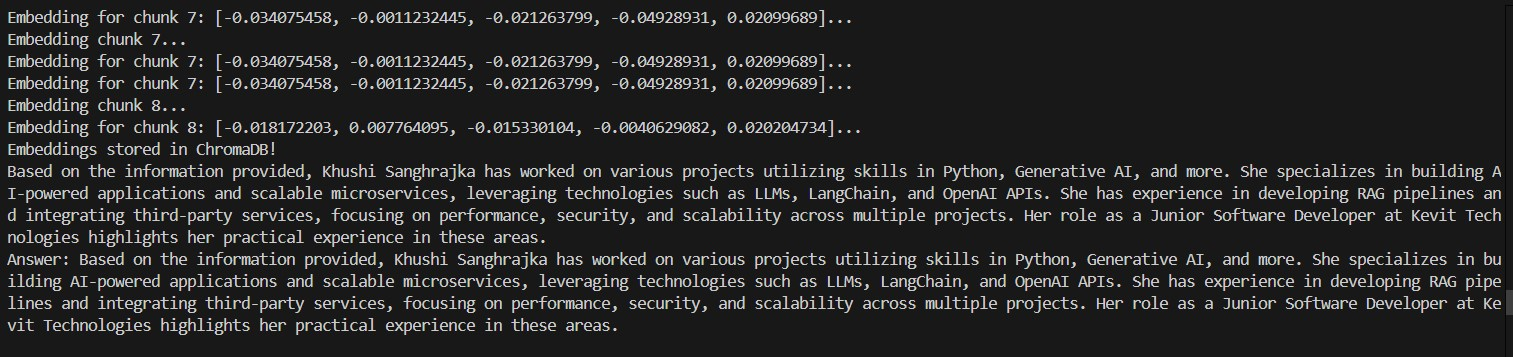